# Deep Learning I - Redes Neurais para Visão Computacional
PUCRS Online - Curso de pós-graduação em Ciência de Dados e Inteligência Artificial

Prof. Martin Duarte Móre

## Material Prático - Classificação

Neste Notebook, exploraremos alguns dos aspectos práticos de implementação de redes neurais profundas para resolução de problemas de Classificação. Para tal, utilizaremos a biblioteca [PyTorch](https://pytorch.org/), que facilita a implementação de redes neurais profundas e seu processo de treinamento.

Especificamente, discutiremos os seguintes conceitos:
- Tensores
- Carregamento, exploração e pré-processamento de dados não-estruturados (imagens)
- Criação de modelos de classificação (Linear, MLP e CNN)
- Implementação do processo de otimização
- Análise de desempenho
- Visualização de representações aprendidas

Para executar os comandos abaixo, é necessário realizar a instalação de uma série de pacotes. Para desenvolvimento local, recomenda-se o uso de GPUs e a instalação completa do [Anaconda](https://www.anaconda.com/), que contém alguns dos pacotes necessários. Além dos pacotes presentes na distribuição do Anaconda, é preciso instalar as bibliotecas presentes no arquivo `environment.yaml`. Consulte a documentação do `conda` para mais detalhes sobre instalação de pacotes. Alternativamente, utilize o [Google Colab](https://colab.research.google.com/) para acesso gratuito à GPUs e um ambiente pré-configurado.

## Imports
Antes de iniciarmos, é necessário importar todos os pacotes.

In [1]:
# carrega a extensão autoreload, que nos permite editar arquivos .py e reimportá-los automaticamente sempre que forem modificados
%load_ext autoreload
%autoreload 2

# bibliotecas nativas
import copy

# bibliotecas instaladas
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

# implementação local
import utils
import visualization as vis

## Tensores

A biblioteca PyTorch possui uma estrutura de dados especializada chamada `Tensor`. É uma estrutura similar ao `ndarray` em NumPy, mas funcionam em *hardware* especializado (e.g., GPUs) e também é otimizada para realizar operações de diferenciação automática. É extremamente importante se familiarizar com tensores, pois todo o funcionamento interno do *framework* é dependente disto. Mais detalhes [neste tutorial](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html).

In [2]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=float, requires_grad=True)
print(x)
print(x.shape)

print()

x = x.view(-1)
print(x)
print(x.shape)

print()

y = torch.tensor(range(len(x)))
print(y)

print()

z = x + y
print(z)

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64, requires_grad=True)
torch.Size([2, 3])

tensor([1., 2., 3., 4., 5., 6.], dtype=torch.float64, grad_fn=<ViewBackward0>)
torch.Size([6])

tensor([0, 1, 2, 3, 4, 5])

tensor([ 1.,  3.,  5.,  7.,  9., 11.], dtype=torch.float64,
       grad_fn=<AddBackward0>)


## Carregando os Dados

Neste Notebook, trabalharemos com o conjunto de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Trata-se de um conjunto de dados de classificação com 10 classes. Cada amostra neste conjunto de dados contém uma imagem e seu rótulo respectivo. O PyTorch já disponibiliza este conjunto de dados, mas é possível implementar o carregamento de dados customizados através da interface [`torch.utils.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) (mais detalhes [aqui](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

In [17]:
cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_train = CIFAR10(
    root='./data',
    train=True,
    transform=T.ToTensor(),
    download=True,
)

data_test = CIFAR10(
    root='./data',
    train=False,
    transform=T.ToTensor(),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


Depois de carregar os dados, vamos inspecionar algumas das instâncias:

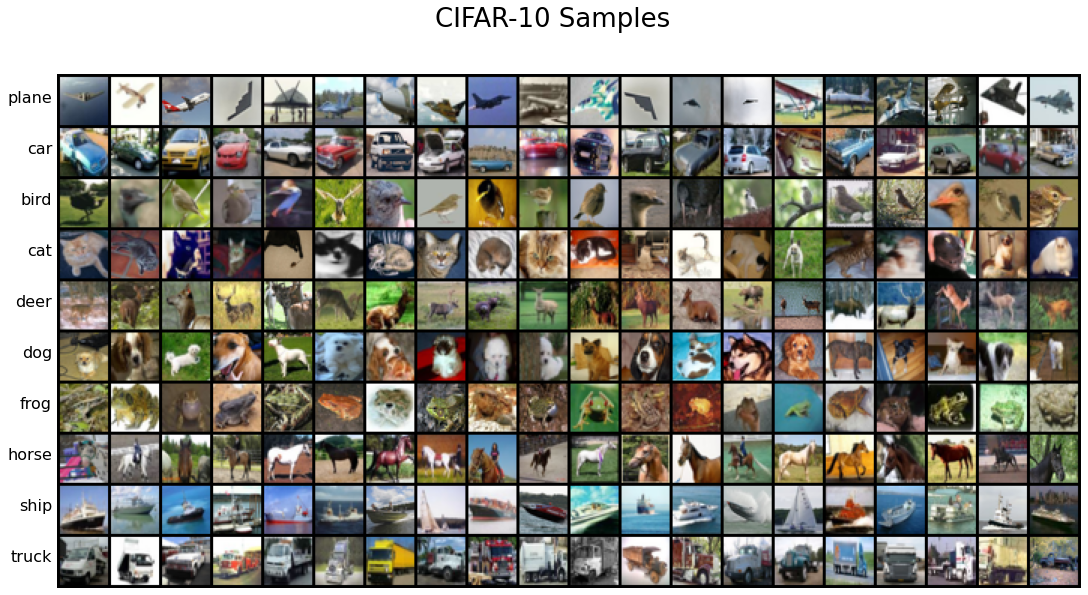

In [4]:
fig = vis.visualize_cifar10(data_train, samples_per_class=20, classes=None, seed=1)
fig.suptitle('CIFAR-10 Samples', fontsize=26)
plt.show()

Após a implementação do conjunto de dados, nosso próximo passo é definir os procedimentos de pré-processamento dos dados.

Antes de passar nossas imagens para a rede neural, vamos executar uma etapa de pré-processamento. Isto é, realizaremos operações de redimensionamento, normalização e data augmentation nas imagens originais. O pré-processamento em tempo de treinamento e teste são um pouco diferentes. Por exemplo, substituiremos as operações estocásticas por suas versões determinísticas ou, caso não seja possível, não as aplicaremos. Desta forma, garantimos a reproducibilidade e comparabilidade entre modelos.

O PyTorch possui uma série de abstrações para pré-processamento de imagens dentro do pacote [`torchvision`](https://pytorch.org/vision/stable/index.html). Você pode ler mais sobre este processo [neste tutorial](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html) ou acessando a [documentação oficial](https://pytorch.org/vision/stable/transforms.html).



In [10]:
mean = [0.49139968, 0.48215827 ,0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]

transforms_train = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

transforms_eval = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

data_train = CIFAR10(
    root='./data',
    train=True,
    transform=transforms_train,
    download=True,
)

data_test = CIFAR10(
    root='./data',
    train=False,
    transform=transforms_eval,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


Vamos inspecionar imagens de algumas instâncias já processadas. Execute a célula abaixo.

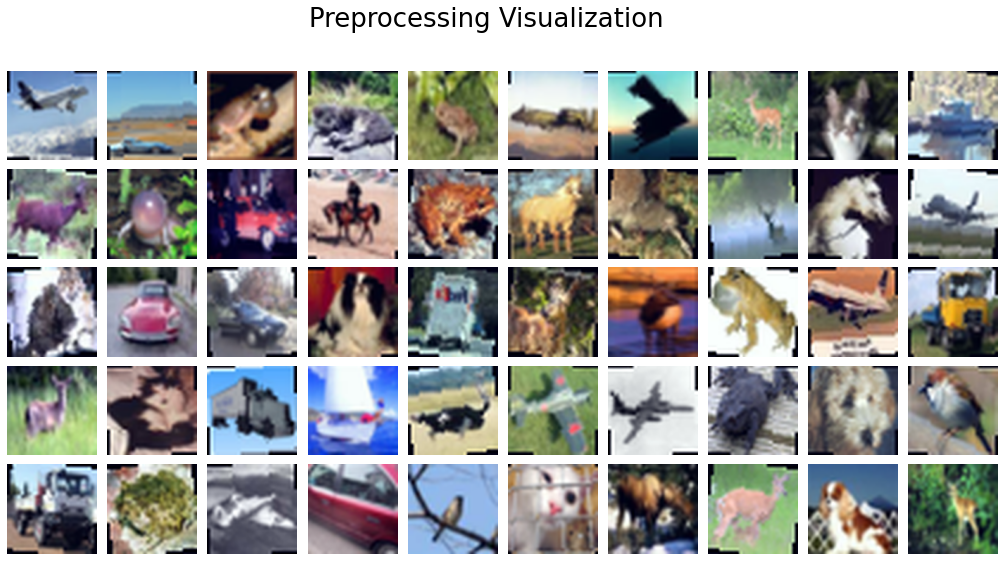

In [11]:
fig = vis.visualize_dataset(data_train, num_instances=50, max_col=10, img_size=128, seed=1)
fig.suptitle('Preprocessing Visualization', fontsize=26)
plt.show()

Com o conjunto de dados em mãos (`torch.utils.data.Dataset`), a próxima etapa é criar um DataLoader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)). Esta classe é responsável por fornecer, de maneira paralelizável, uma abstração de amostragem (estocástica ou determinística) e iteração por nossos dados. Dependendo do subconjunto solicitado, devemos embaralhar (ou não) as instâncias. De maneira similar, as transformações aplicadas também se alteram quando estamos treinando ou avaliando o modelo.

Você pode ler mais sobre esse processo [neste tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders).

In [18]:
loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

loader_test = torch.utils.data.DataLoader(
    data_test,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## Criando um Classificador Linear

Agora, implementaremos um modelo de rede neural profunda totalmente conectada. O PyTorch disponibiliza diversos pacotes para nos auxiliar a fazer um design de redes neurais profundas de maneira eficiente.

O pacote `torch.nn` disponibiliza camadas pré-definidas para facilitar a construção de redes neurais. Estas camadas são uma subclasse de [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), que gerencia automaticamente o dispositivo computacional, os parâmetros e o fluxo de operações de uma camada. Quando definimos as operações em uma rede neural (e.g., convoluções, camadas lineares, camadas de pooling, etc.), quase sempre utilizamos as definições contidas neste pacote. Quando o PyTorch não disponibiliza uma camada que desejamos, basta herdar de `torch.nn.Module` e realizar a implementação!

A rede neural que iremos construir será especificada através de um módulo, e consistirá de vários outros módulos. Alguns destes módulos serão pré-definidos; os demais, construiremos nós mesmos. Esta estrutura aninhada nos permitirá abstrair a computação realizada por cada camada da rede e também facilitará a nossa construção do modelo. Você pode ler mais a respeito de construção de redes utilizando PyTorch [neste tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [19]:
class LinearClassifier(nn.Module):
    def __init__(self, dim_data, num_classes):
        super().__init__()
        self.layer = nn.Linear(
            in_features=dim_data,
            out_features=num_classes,
            bias=False,
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        out = self.layer(x)
        return out
    
model_linear = LinearClassifier(dim_data=3*32*32, num_classes=10)
print(model_linear)

LinearClassifier(
  (layer): Linear(in_features=3072, out_features=10, bias=False)
)


## Definindo o Processo de Otimização

Agora, vamos definir a função responsável por realizar o processo de otimização de nossas redes. Para mais detalhes sobre o processo de otimização, consulte [este tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

Quando treinamos redes neurais, o algoritmo de atualização de pesos mais comumente utilizado é o *backpropagation*. Neste algoritmo, os pesos são atualizados através do gradiente de uma função de custo para cada parâmetro individual. Este processo é abstraído significativamente no PyTorch através do pacote `torch.autograd`. Este pacote disponibiliza classes e funções que implementam o processo de diferenciação automática de funções arbitrárias dentro de um grafo computacional. A rede neural que criamos é justamente isso: um grafo computacional que define a interação entre as entradas e os parâmetros de cada camada. Você pode ler mais a respeito de diferenciação automática no PyTorch [neste tutorial](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html).

O processo de treinamento de redes neurais é iterativo. Em cada iteração, amostramos do nosso conjunto de dados (`torch.utils.data.DataLoader`), calculamos a saída do modelo (*forward*, `torch.nn.Module`), computamos as derivadas (*backward*, `torch.autograd`) e atualizamos os pesos. Este processo de atualização de pesos depende de um otimizador, como o Gradiente Descendente Estocástico (SGD). Existem diversos tipos de otimizador; cada um atualiza os pesos do modelo de maneira diferente. O PyTorch abstrai o conceito de otimizadores no pacote `torch.optim`. Você pode ler mais a respeito de otimizadores no PyTorch [aqui](https://pytorch.org/docs/stable/optim.html).

In [14]:
def train(train_loader, model, num_epochs, print_freq):
    # activate training mode
    model.train()
    
    # pick device depending on GPU availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # send model to device
    model = model.to(device)
    
    # create optimization criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
    
    train_loader_len = len(train_loader)
    
    # saving losses to plot later
    losses = []
    losses_smooth = []
    loss_smooth = 0
    
    # iterate num_epoch times over entire dataset
    for epoch in range(num_epochs):
        # iterate through mini-batches
        for i, (x, y) in enumerate(train_loader):
            iter_num = (epoch * train_loader_len) + i + 1
            
            # send mini-batch data to device
            x = x.to(device)
            y = y.to(device)

            # compute model output (forward pass) and loss
            out = model(x)
            loss = criterion(out, y)

            if iter_num == 1:
                loss_smooth = loss.item()
            else:
                # exponential moving average of loss (easier to visualize)
                loss_smooth = 0.99 * loss_smooth + 0.01 * loss.item()
            losses.append(loss.item())
            losses_smooth.append(loss_smooth)

            # zero gradients in optimizer, perform backward pass, and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # logging during training
            if (iter_num % print_freq) == 0:
                run_info = (
                    'epoch: [{:3d}/{:3d}] | step: [{:4d}/{:4d}] | loss_smooth: {:.4f} | loss: {:.4f}'
                ).format(epoch+1, num_epochs, (i+1), train_loader_len, loss_smooth, loss)
                print(run_info)

    # return losses for plotting
    return losses, losses_smooth

## Treinando o Modelo Linear

Após definir o processo de treinamento, podemos realizar o processo de otimização de nossa rede neural profunda!

epoch: [  1/ 10] | step: [1000/1563] | loss_smooth: 2.0386 | loss: 2.1099
epoch: [  2/ 10] | step: [ 437/1563] | loss_smooth: 1.9440 | loss: 1.7308
epoch: [  2/ 10] | step: [1437/1563] | loss_smooth: 1.9175 | loss: 1.8938
epoch: [  3/ 10] | step: [ 874/1563] | loss_smooth: 1.8820 | loss: 1.8964
epoch: [  4/ 10] | step: [ 311/1563] | loss_smooth: 1.8700 | loss: 1.8085
epoch: [  4/ 10] | step: [1311/1563] | loss_smooth: 1.8350 | loss: 1.8506
epoch: [  5/ 10] | step: [ 748/1563] | loss_smooth: 1.8584 | loss: 1.8504
epoch: [  6/ 10] | step: [ 185/1563] | loss_smooth: 1.8223 | loss: 1.7773
epoch: [  6/ 10] | step: [1185/1563] | loss_smooth: 1.8307 | loss: 1.6047
epoch: [  7/ 10] | step: [ 622/1563] | loss_smooth: 1.8296 | loss: 1.5528
epoch: [  8/ 10] | step: [  59/1563] | loss_smooth: 1.7999 | loss: 1.6268
epoch: [  8/ 10] | step: [1059/1563] | loss_smooth: 1.8027 | loss: 2.1484
epoch: [  9/ 10] | step: [ 496/1563] | loss_smooth: 1.7745 | loss: 1.5158
epoch: [  9/ 10] | step: [1496/1563] |

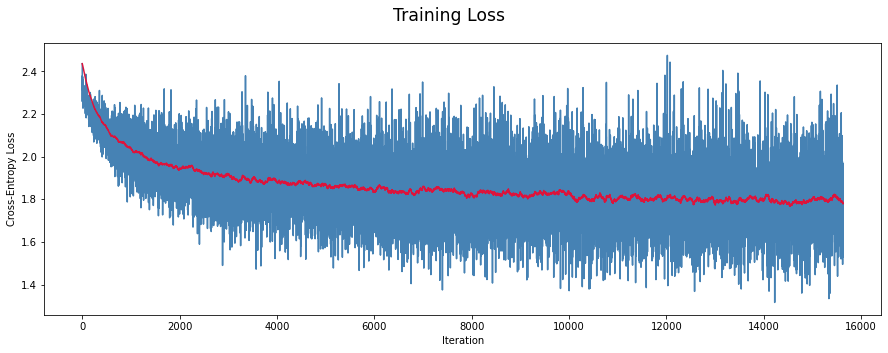

In [20]:
losses, losses_smooth = train(loader_train, model_linear, num_epochs=10, print_freq=1000)
print('Training complete. Plotting loss curve and saving weights...')

fig = vis.visualize_losses(losses, losses_smooth)
plt.show()

torch.save(model_linear.state_dict(), './ckpt/model_linear_cifar10.pth')

## Visualizando Templates

Para entender que tipo de características (*features*) nosso modelo linear aprendeu, podemos visualizar os pesos da matriz para cada classe.

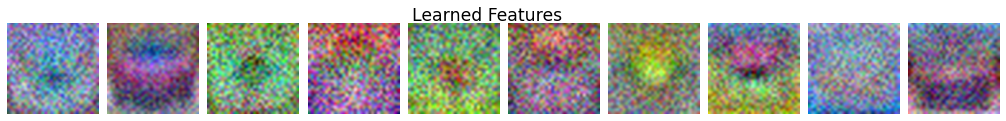

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [21]:
w = model_linear.layer.weight.cpu().clone()
fig = vis.visualize_templates(w, dim_data=[3, 32, 32])
fig.suptitle('Learned Features', fontsize='xx-large')
plt.show()
print(cifar_classes)

## Definindo Avaliação

Depois de implementar o processo de treinamento, ainda resta definir o processo de avaliação de nosso classificador.

In [22]:
def evaluate(loader_test, model, classes):
    # activate evaluation mode
    model.eval()
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    correct = 0
    total = 0

    cls_correct = {cls: 0 for cls in classes}
    cls_total   = {cls: 0 for cls in classes}

    with torch.no_grad():
        for i, (x, y) in enumerate(loader_test):
            curr_batch_size = x.shape[0]
            
            x = x.to(device)
            y = y.to(device)

            # get model output and select class with highest probability
            out = model(x)
            preds = out.argmax(dim=1)

            # log per-class classification results
            for label, pred in zip(y, preds):
                if label == pred:
                    cls_correct[classes[label]] += 1
                cls_total[classes[label]] += 1

            # log overall classification results
            num_correct = (preds == y).sum().item()
            total += curr_batch_size
            correct += num_correct

    # transform accuracy into percentage values
    acc = lambda correct, total: 100.0 * correct / total
    accuracy_overall = acc(correct, total)

    accuracy_cls = {}
    for cls, num_correct in cls_correct.items():
        accuracy_cls[cls] = acc(num_correct, cls_total[cls])
        
    return accuracy_overall, accuracy_cls

## Avaliando o Modelo Linear

Após otimizar nosso modelo, vamos avaliar seu desempenho!

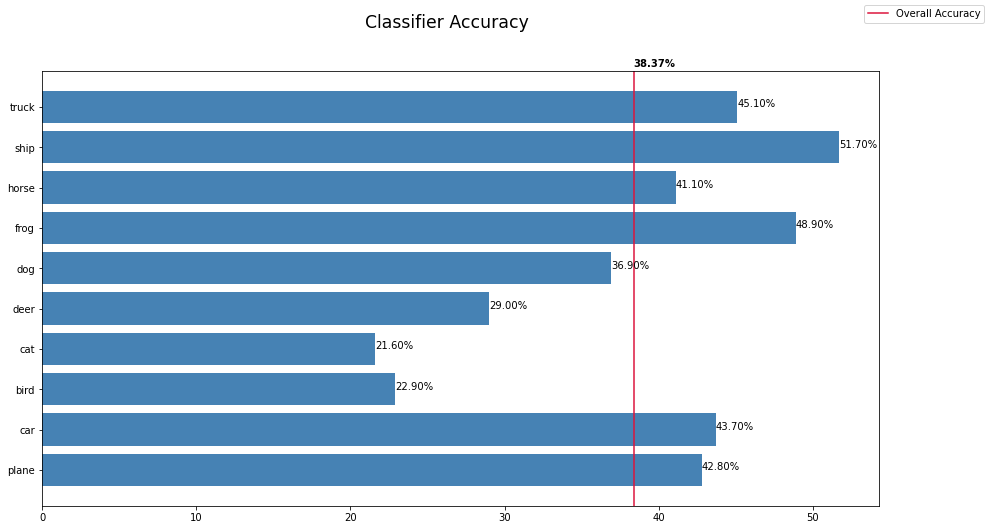

In [23]:
acc_overall, acc_cls = evaluate(loader_test, model_linear, classes=cifar_classes)
fig_eval = vis.visualize_evaluation(acc_overall, acc_cls)
plt.show()

## Criando um Modelo MLP

Vamos criar um modelo MLP da mesma forma que fizemos o modelo linear, através da interface `nn.Module`.

In [24]:
class MLPClassifier(nn.Module):
    def __init__(self, dim_data, dim_hidden, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim_data, dim_hidden, bias=False),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=False),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=False),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=False),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, num_classes, bias=False),
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        out = self.layers(x)
        return out
    
model_mlp = MLPClassifier(dim_data=3*32*32, dim_hidden=100, num_classes=10)
print(model_mlp)

MLPClassifier(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=False)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=False)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=10, bias=False)
  )
)


## Treinando um Modelo MLP

epoch: [  1/ 10] | step: [1000/1563] | loss_smooth: 1.9438 | loss: 1.9133
epoch: [  2/ 10] | step: [ 437/1563] | loss_smooth: 1.8050 | loss: 2.0143
epoch: [  2/ 10] | step: [1437/1563] | loss_smooth: 1.7032 | loss: 1.6191
epoch: [  3/ 10] | step: [ 874/1563] | loss_smooth: 1.6469 | loss: 1.6485
epoch: [  4/ 10] | step: [ 311/1563] | loss_smooth: 1.5979 | loss: 1.5524
epoch: [  4/ 10] | step: [1311/1563] | loss_smooth: 1.5925 | loss: 1.4759
epoch: [  5/ 10] | step: [ 748/1563] | loss_smooth: 1.5336 | loss: 1.7364
epoch: [  6/ 10] | step: [ 185/1563] | loss_smooth: 1.4956 | loss: 1.2888
epoch: [  6/ 10] | step: [1185/1563] | loss_smooth: 1.4942 | loss: 1.5289
epoch: [  7/ 10] | step: [ 622/1563] | loss_smooth: 1.4643 | loss: 1.4646
epoch: [  8/ 10] | step: [  59/1563] | loss_smooth: 1.4457 | loss: 1.3800
epoch: [  8/ 10] | step: [1059/1563] | loss_smooth: 1.4407 | loss: 1.4501
epoch: [  9/ 10] | step: [ 496/1563] | loss_smooth: 1.3974 | loss: 1.2701
epoch: [  9/ 10] | step: [1496/1563] |

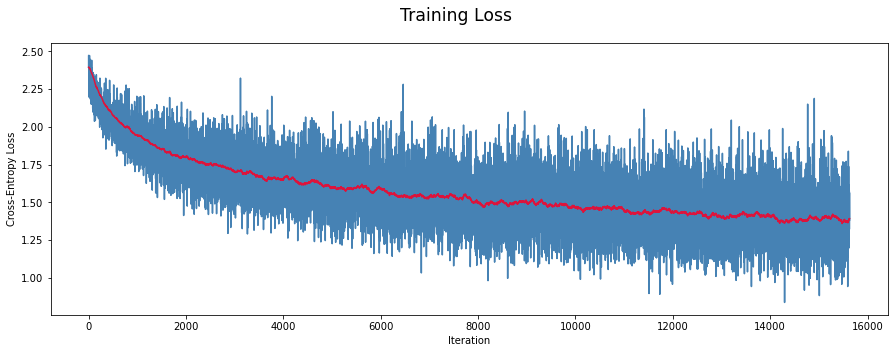

In [25]:
losses, losses_smooth = train(loader_train, model_mlp, num_epochs=10, print_freq=1000)
print('Training complete. Plotting loss curve and saving weights...')

fig = vis.visualize_losses(losses, losses_smooth)
plt.show()

torch.save(model_mlp.state_dict(), './ckpt/model_mlp_cifar10.pth')

## Avaliando o Modelo MLP

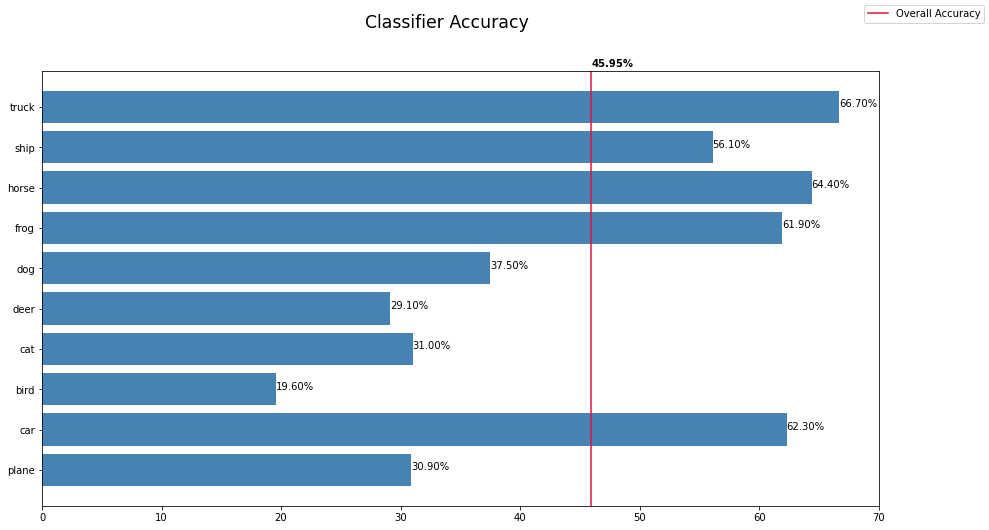

In [26]:
acc_overall, acc_cls = evaluate(loader_test, model_mlp, classes=cifar_classes)
fig_eval = vis.visualize_evaluation(acc_overall, acc_cls)
plt.show()

## Visualizando *Features* Aprendidas

Durante o treinamento, uma rede neural profunda aprende a identificar e organizar os conceitos (*features*) necessários para o aprendizado em um espaço latente multidimensional. Podemos inspecionar as *features* de algumas amostras e visualizar os vizinhos mais próximos delas, dentro deste espaço aprendido. Desta forma, podemos "validar" manualmente a robustez do modelo, comparando as imagens semelhantes.

Primeiro, vamos fazer uma "cirurgia" em nosso modelo: a última camada linear projeta as *features* aprendidas para um vetor de C dimensões (número de categorias). Se removermos esta última camada, teremos a informação semântica da instância processada.

In [27]:
# copy model
model_mlp_headless = copy.deepcopy(model_mlp)
print(model_mlp_headless)
print()

# remove last layer
model_mlp_headless.layers = nn.Sequential(*list(model_mlp_headless.layers.children())[:-1])
# place model in evaluation mode
model_mlp_headless.eval()

MLPClassifier(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=False)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=False)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=10, bias=False)
  )
)



MLPClassifier(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=False)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=False)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)

In [28]:
# create evaluation dataset
nn_data = CIFAR10(
    root='./data',
    train=False,
    transform=transforms_eval,
    download=True,
)

Files already downloaded and verified


tensor([2382, 6032, 4944,  859, 9464, 2252,  472,  687, 9755, 9870])
torch.Size([10, 3, 32, 32])


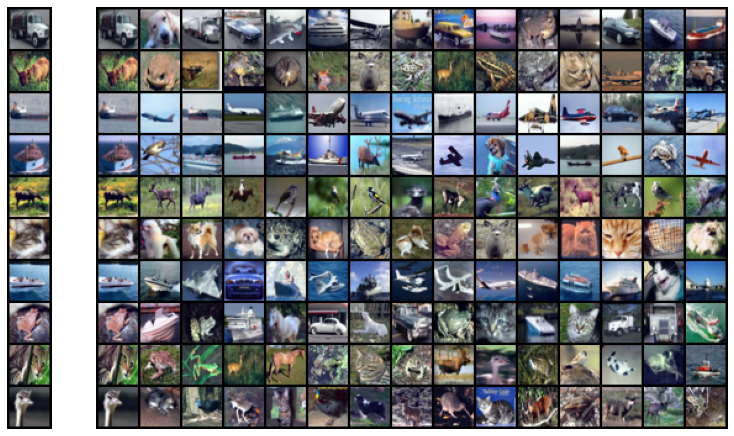

In [31]:
# draw sample indices
seed_nn = 123
num_instances = 10

gen = torch.Generator().manual_seed(seed_nn)
instance_ids = torch.randperm(len(nn_data), generator=gen)[:num_instances]
print(instance_ids)

# collect instances from dataset using selected indices
samples = torch.stack([nn_data[i][0] for i in instance_ids])
print(samples.shape)

# plot nearest neighbors at feature level
fig_neighbors = vis.visualize_neighbors(samples, nn_data, model_mlp_headless, k=15)
plt.show()

## Criando Modelo Convolucional

O PyTorch disponibiliza diversas camadas para montarmos nossa arquitetura de rede neural profunda. Agora, vamos montar uma arquitetura de rede convolucional!

In [32]:
class ConvBlock(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=dim_in,
            out_channels=dim_out,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(dim_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out


class CNNClassifier(nn.Module):
    def __init__(self, dim_data, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 64),                      # [3, 32, 32] -> [64, 32, 32]
            ConvBlock(64, 64),                     # [64, 32, 32] -> [64, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2), # [64, 32, 32] -> [64, 16, 16]
            
            ConvBlock(64, 64),                     # [64, 16, 16] -> [64, 16, 16]
            ConvBlock(64, 128),                    # [64, 16, 16] -> [128, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2), # [128, 16, 16] -> [128, 8, 8]
            
            ConvBlock(128, 128),                   # [128, 8, 8] -> [128, 8, 8]
            ConvBlock(128, 256),                   # [128, 8, 8] -> [256, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2), # [256, 8, 8] -> [256, 4, 4]
            
            ConvBlock(256, 256),                   # [256, 4, 4] -> [256, 4, 4]
            ConvBlock(256, 512),                   # [256, 4, 4] -> [512, 4, 4]
            nn.MaxPool2d(kernel_size=4, stride=4), # [512, 4, 4] -> [512, 1, 1]
        )
        self.linear = nn.Linear(512, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = self.layers(x)                     # [B, 3, 32, 32] -> [B, 512, 1, 1]
        out = out.view(batch_size, out.shape[1]) # [B, 512, 1, 1] -> [B, 512]
        out = self.linear(out)                   # [B, 512] -> [B, 10]
        return out
    
model_cnn = CNNClassifier(dim_data=3*32*32, num_classes=10)
print(model_cnn)

CNNClassifier(
  (layers): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## Treinando Modelo Convolucional

epoch: [  1/ 10] | step: [1000/1563] | loss_smooth: 1.3645 | loss: 1.3145
epoch: [  2/ 10] | step: [ 437/1563] | loss_smooth: 1.1218 | loss: 1.1722
epoch: [  2/ 10] | step: [1437/1563] | loss_smooth: 1.0092 | loss: 1.2271
epoch: [  3/ 10] | step: [ 874/1563] | loss_smooth: 0.8794 | loss: 1.0323
epoch: [  4/ 10] | step: [ 311/1563] | loss_smooth: 0.7565 | loss: 1.1446
epoch: [  4/ 10] | step: [1311/1563] | loss_smooth: 0.7408 | loss: 0.7890
epoch: [  5/ 10] | step: [ 748/1563] | loss_smooth: 0.6587 | loss: 0.7067
epoch: [  6/ 10] | step: [ 185/1563] | loss_smooth: 0.5861 | loss: 0.7332
epoch: [  6/ 10] | step: [1185/1563] | loss_smooth: 0.5649 | loss: 0.4548
epoch: [  7/ 10] | step: [ 622/1563] | loss_smooth: 0.4689 | loss: 0.2821
epoch: [  8/ 10] | step: [  59/1563] | loss_smooth: 0.4447 | loss: 0.3933
epoch: [  8/ 10] | step: [1059/1563] | loss_smooth: 0.4104 | loss: 0.3642
epoch: [  9/ 10] | step: [ 496/1563] | loss_smooth: 0.3266 | loss: 0.2736
epoch: [  9/ 10] | step: [1496/1563] |

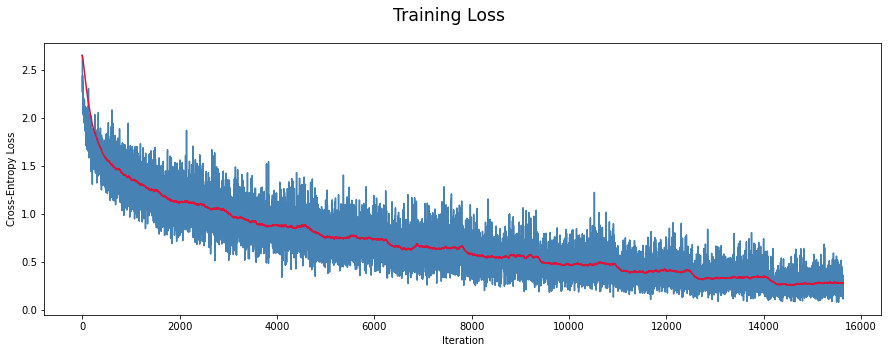

In [33]:
losses, losses_smooth = train(loader_train, model_cnn, num_epochs=10, print_freq=1000)
print('Training complete. Plotting loss curve and saving weights...')

fig = vis.visualize_losses(losses, losses_smooth)
plt.show()

torch.save(model_cnn.state_dict(), './ckpt/model_cnn_cifar10.pth')

## Visualizando Filtros Convolucionais

Para entender que tipo de características (*features*) nosso modelo convolucional aprendeu, podemos visualizar os pesos dos filtros da primeira camada.

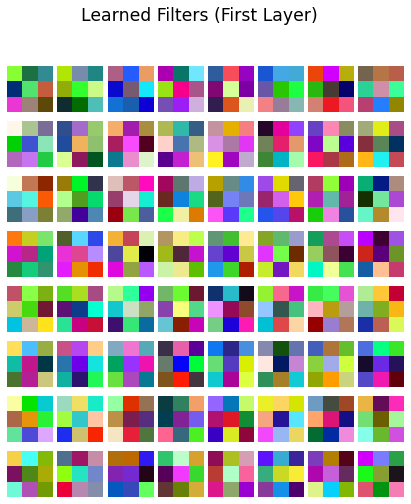

In [34]:
w = model_cnn.layers[0].conv.weight.cpu().clone()
fig = vis.visualize_cnn_filters(w, max_col=8)
fig.suptitle('Learned Filters (First Layer)', fontsize='xx-large')
plt.show()

Exemplo de filtros aprendidos de um modelo pré-treinado: [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html).

Mais sobre modelos pré-treinados [aqui](https://pytorch.org/vision/stable/models.html).

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

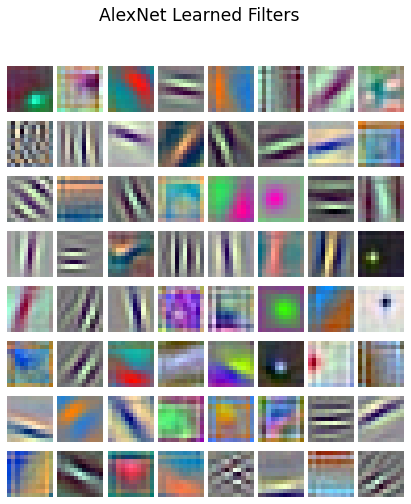

In [35]:
alexnet = torchvision.models.alexnet(pretrained=True)
print(alexnet)

w = alexnet.features[0].weight.cpu().clone()
fig = vis.visualize_cnn_filters(w, max_col=8)
fig.suptitle('AlexNet Learned Filters', fontsize='xx-large')
plt.show()

Além disso, podemos visualizar também os vizinhos mais próximos:

In [36]:
# copy model
model_cnn_headless = copy.deepcopy(model_cnn)
print(model_cnn_headless)
print()

# remove last layer
model_cnn_headless.linear = nn.Identity()
# place model in evaluation mode
model_cnn_headless.eval()

CNNClassifier(
  (layers): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

CNNClassifier(
  (layers): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

tensor([2382, 6032, 4944,  859, 9464, 2252,  472,  687, 9755, 9870])
torch.Size([10, 3, 32, 32])


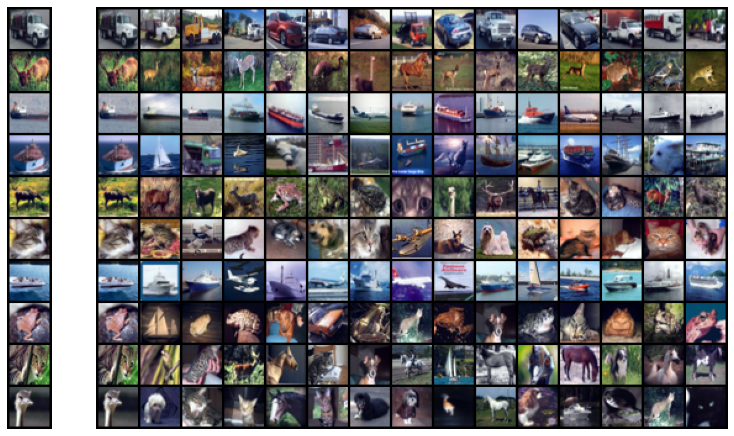

In [38]:
# draw sample indices
seed_nn = 123
num_instances = 10

gen = torch.Generator().manual_seed(seed_nn)
instance_ids = torch.randperm(len(nn_data), generator=gen)[:num_instances]
print(instance_ids)

# collect instances from dataset using selected indices
samples = torch.stack([nn_data[i][0] for i in instance_ids])
print(samples.shape)

# plot nearest neighbors at feature level
fig_neighbors = vis.visualize_neighbors(samples, nn_data, model_cnn_headless, k=15)
plt.show()

## Avaliando Modelo Convolucional

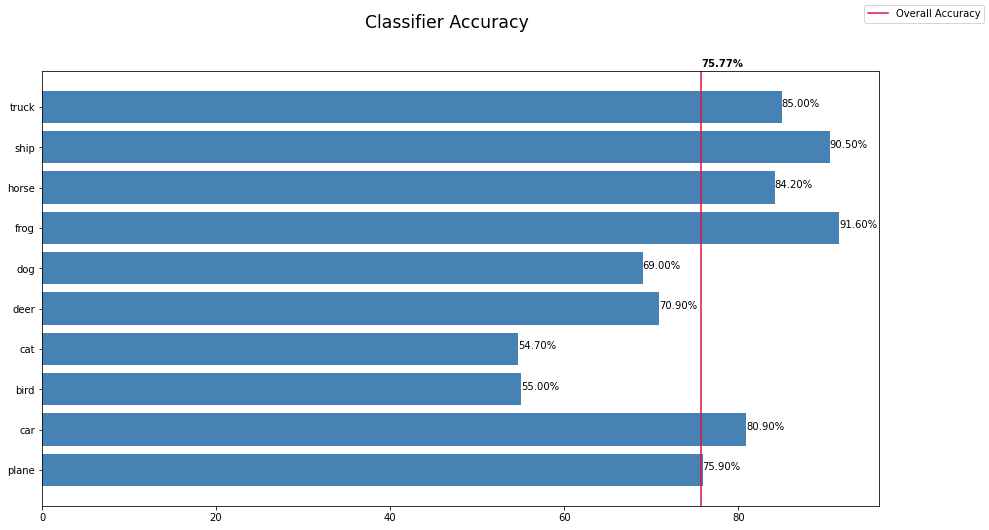

In [39]:
acc_overall, acc_cls = evaluate(loader_test, model_cnn, classes=cifar_classes)
fig_eval = vis.visualize_evaluation(acc_overall, acc_cls)
plt.show()

## Carregando Pesos

Depois de efetuar o treinamento de um modelo, podemos carregar os pesos salvos nas etapas anteriores. **ATENÇÃO**: colocar em modo de avaliação! Mais informações [aqui](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
model = CNNClassifier(dim_data=3*32*32, num_classes=10)
weights = torch.load('./ckpt/model_cnn_cifar10.pth')
model.load_state_dict(weights)
model.eval()

# PROSSEGUIR COM INFERÊNCIA
x = torch.randn([1, 3, 32, 32])
out = model(x)
print(out.shape)
print()

out_cls = out.argmax(dim=1)
print(out_cls)
print(cifar_classes[out_cls])

# Fim do Notebook